# Bank Marketing analysis

### By: Andy Hwang

#### Data Set Information:

#### from: https://archive.ics.uci.edu/ml/datasets/bank+marketing

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

There are four datasets:
1) bank-additional-full.csv with all examples (41188) and 20 inputs, ordered by date (from May 2008 to November 2010), very close to the data analyzed in [Moro et al., 2014]
2) bank-additional.csv with 10% of the examples (4119), randomly selected from 1), and 20 inputs.
3) bank-full.csv with all examples and 17 inputs, ordered by date (older version of this dataset with less inputs).
4) bank.csv with 10% of the examples and 17 inputs, randomly selected from 3 (older version of this dataset with less inputs).
The smallest datasets are provided to test more computationally demanding machine learning algorithms (e.g., SVM).

The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).


Attribute Information:

Input variables:
#### bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
#### related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
#### other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
#### social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')



# Dependencies

In [185]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kurtosis
import seaborn as sns
import numpy as np
import math
import functools
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder

# Import csv
df = pd.read_csv('bank-additional/bank-additional-full.csv', delimiter = ';')

# data pre-processing

## Summary statistics

The data set contains 41,188 observations and 21 variables including the binary response variable, y (subscribe term deposit - Yes/No).

Of these columns, 10 are numeric and 11 are objects (categorical or binary). 

We see that there is no missing value from summary statistics and data information. Note that from histogram, we see that some numeric variables are fairly negatively/positively skewed which may need to be addressed through data transformation or feature selection before developing a parametric model. 

For our purpose, however, since we are going to focus on non-parametric models only such as Random Forest and XGBoost, normality assumption is not needed and therefore, further data transformation such as using box-cox/log will not be performed.

reference: https://stackoverflow.com/questions/8961586/do-i-need-to-normalize-or-scale-data-for-randomforest-r-package

Although we do not have any null value, we have to watch out for a situation where some of the non-null values that may actually indicate "non-existing/missing" in terms of business perspective. We see that "pdays" is mostly filled with 999 from summary statistics. From data dictionary we learned that pdays = 999 means client was not previously contacted and this variable should be related to variables such as previous or poutcome. Indeed, as we can see from the cross-table, pdays = 999 occurs mostly when the "poutcome" is "non-existent". This means that the majority of the customers were never contacted before. We can consider removing this variable as it is missing too many values.

We will also drop 'duration' variable as it is only known after the call (refrence from data dictionary: "Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known."). In other words, when duration = 0, it is obvious that y is "no". The 'duration' variable can lead to data leakage in prediction model and thus any model including such variable will not represent the reality well enough.

Histogram and boxplot tell us that there are outliers in the data but as we will design tree-models only that are robust to outliers, we would not necessarily handle them. Not only that, from business perspective, since we want to reflect the reality of the world as much as we can, we would keep them as they are. We see that the value of these outliers are not so unrealistic anyway (for example, max of age is 98) and therefore, we do not need to remove them. We want our model to be robust for real world situations and hence, the outliers are not removed.

reference: https://datascience.stackexchange.com/questions/37394/are-decision-trees-robust-to-outliers

In [186]:
df['y'].unique()

array(['no', 'yes'], dtype=object)

In [187]:
print("Summary statistics:")
df.describe()

Summary statistics:


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [188]:
# special examination for pdays
pd.crosstab(df['pdays'],df['previous'], values=df['age'], aggfunc='count', normalize=True)

previous,0,1,2,3,4,5,6,7
pdays,,,,,,,,
0,0.000000,0.000170,0.000097,0.000049,0.000024,0.000024,0.000000,0.000000
1,0.000000,0.000388,0.000121,0.000073,0.000024,0.000000,0.000024,0.000000
2,0.000000,0.001020,0.000291,0.000073,0.000073,0.000024,0.000000,0.000000
3,0.000000,0.006070,0.002768,0.001044,0.000461,0.000219,0.000073,0.000024
4,0.000000,0.001772,0.000704,0.000340,0.000049,0.000000,0.000000,0.000000
5,0.000000,0.000680,0.000267,0.000121,0.000000,0.000049,0.000000,0.000000
6,0.000000,0.005341,0.002841,0.001384,0.000388,0.000049,0.000000,0.000000
7,0.000000,0.000631,0.000558,0.000194,0.000073,0.000000,0.000000,0.000000
8,0.000000,0.000219,0.000146,0.000049,0.000024,0.000000,0.000000,0.000000


In [189]:
# special examination for pdays
pd.crosstab(df['pdays'],df['poutcome'], values=df['age'], aggfunc='count', normalize=True)

poutcome,failure,nonexistent,success
pdays,,,
0,0.000000,0.000000,0.000364
1,0.000000,0.000000,0.000631
2,0.000000,0.000000,0.001481
3,0.000097,0.000000,0.010561
4,0.000049,0.000000,0.002816
5,0.000097,0.000000,0.001020
6,0.000607,0.000000,0.009396
7,0.000364,0.000000,0.001093
8,0.000146,0.000000,0.000291


In [190]:
print("Data information")
df.info()

Data information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx 

In [191]:
print("Kurtosis statistics:")
print(df.kurtosis())

Kurtosis statistics:
age                0.791312
duration          20.247938
campaign          36.979795
pdays             22.229463
previous          20.108816
emp.var.rate      -1.062632
cons.price.idx    -0.829809
cons.conf.idx     -0.358558
euribor3m         -1.406803
nr.employed       -0.003760
dtype: float64


In [192]:
print("Skewness statistics:")
print(df.skew())

Skewness statistics:
age               0.784697
duration          3.263141
campaign          4.762507
pdays            -4.922190
previous          3.832042
emp.var.rate     -0.724096
cons.price.idx   -0.230888
cons.conf.idx     0.303180
euribor3m        -0.709188
nr.employed      -1.044262
dtype: float64


In [193]:
print("Percent of missing rows")
print( ( df.isnull().sum()/len(df) ) * 100 )

Percent of missing rows
age               0.0
job               0.0
marital           0.0
education         0.0
default           0.0
housing           0.0
loan              0.0
contact           0.0
month             0.0
day_of_week       0.0
duration          0.0
campaign          0.0
pdays             0.0
previous          0.0
poutcome          0.0
emp.var.rate      0.0
cons.price.idx    0.0
cons.conf.idx     0.0
euribor3m         0.0
nr.employed       0.0
y                 0.0
dtype: float64


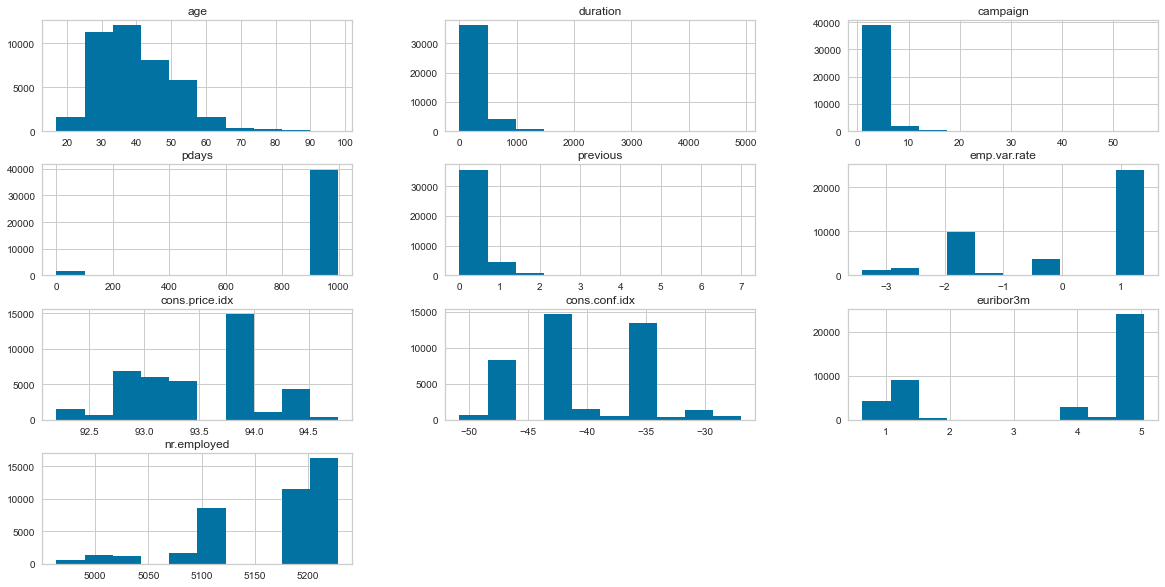

In [194]:
df.hist(figsize=(20,10))
plt.show()

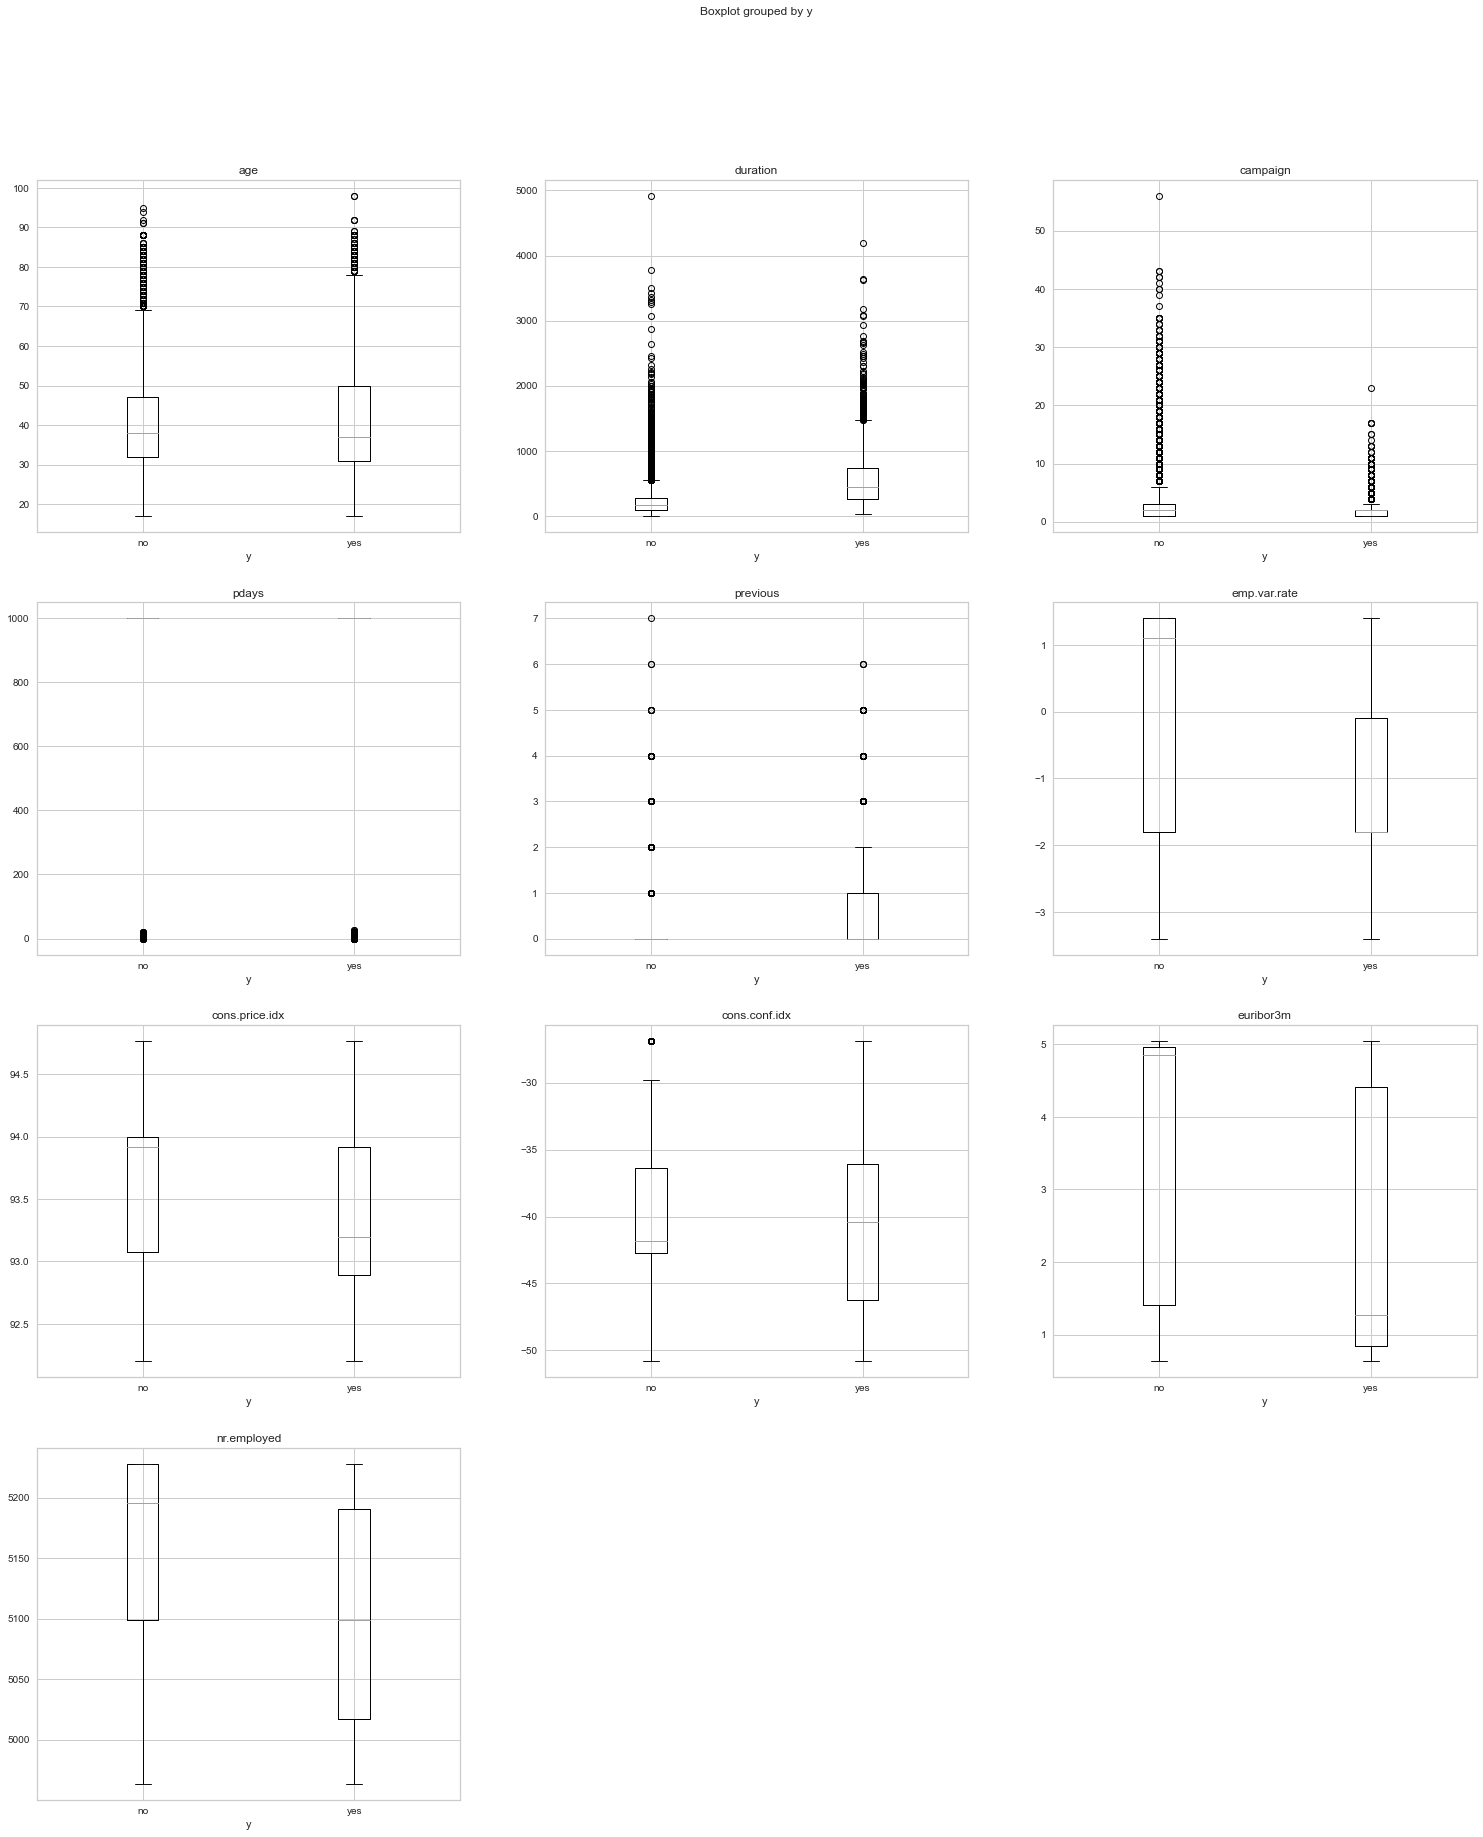

In [195]:
fig, axes = plt.subplots(4,3, figsize=(25,30)) # create figure and axes
names = list(df.select_dtypes(include=[np.number]))
#names.remove('y')

for i,el in enumerate(names):
    a = df.boxplot(el, by="y", ax=axes.flatten()[i])

fig.delaxes(axes[3,1]) # remove empty subplot
fig.delaxes(axes[3,2])
plt.show()

In [196]:
## drop pdays
df.drop('pdays', axis = 1, inplace = True)

In [197]:
## drop duration
df.drop('duration', axis = 1, inplace = True)

# Feature engineering

## OneHotEncoder

OneHotEncoder will create binary values for each categorical varialbe. This procedure will treat categorical variables as nominal instead of being ordinal for modelling later on. We need this process as many of categorical variables are in letters (we want to convert them into binary variable for each level). 

After converting categorical variables into binary form, we will then remove "unknown" level as we do not want to consider ambiguities (and hence, fill rate of "unknown" is not that high so we are not losing huge chunk of information). In real world, "unknown" would imply the information does not exist and hence we will remove them.

Dummy variable trap is common problem for parametric equation but as we are using non-linear tree model, dropping one of the levels for each dummy feature (considering only n-1 levels) would not be performed unless it has level of 2 only. 
(reference: https://stats.stackexchange.com/questions/177852/best-practices-for-coding-categorical-features-for-decision-trees). In other words, we will, however, still drop one of the levels for variables that have level of 2; as the variables will have perfect collinearity and it can distort feature importance plot. 
(reference: https://datascience.stackexchange.com/questions/12554/does-xgboost-handle-multicollinearity-by-itself)



In [198]:
# Dummy variable with one hot-coded
ohe = ce.OneHotEncoder(handle_unknown='ignore', use_cat_names=True)
df_model = ohe.fit_transform(df)

### checking fill rate for "unknown"

In [199]:
df_model.columns[df_model.columns.str.contains('_unknown')]

Index(['job_unknown', 'marital_unknown', 'education_unknown',
       'default_unknown', 'housing_unknown', 'loan_unknown'],
      dtype='object')

In [200]:
df.groupby('job').size()

job
admin.           10422
blue-collar       9254
entrepreneur      1456
housemaid         1060
management        2924
retired           1720
self-employed     1421
services          3969
student            875
technician        6743
unemployed        1014
unknown            330
dtype: int64

In [201]:
df.groupby('marital').size()

marital
divorced     4612
married     24928
single      11568
unknown        80
dtype: int64

In [202]:
df.groupby('education').size()

education
basic.4y                4176
basic.6y                2292
basic.9y                6045
high.school             9515
illiterate                18
professional.course     5243
university.degree      12168
unknown                 1731
dtype: int64

In [203]:
df.groupby('default').size()

default
no         32588
unknown     8597
yes            3
dtype: int64

In [204]:
df.groupby('housing').size()

housing
no         18622
unknown      990
yes        21576
dtype: int64

In [205]:
df.groupby('loan').size()

loan
no         33950
unknown      990
yes         6248
dtype: int64

In [206]:
### drop unknowns
df_model.drop(df_model.columns[df_model.columns.str.contains('_unknown')], axis=1, inplace = True)

In [207]:
### drop _no as now we have 2 levels for categorical variables with yes/no
#df_model.columns[df_model.columns.str.contains('_no')]
df_model.drop(['default_no', 'housing_no', 'loan_no'],axis=1, inplace = True)

## features and label
y is the label and anything else becomes features.

In [208]:
# from above, it then creates 2 columns for y - y_yes/y_no. Use only y_yes (1- yes, 0 - no) as label
df_model.rename(columns={'y_yes':'y'}, inplace = True)
df_model.drop('y_no',axis = 1, inplace = True)

# features
x = df_model.iloc[:,:-1]

# label
y = df_model['y']

# EDA

## Correlation Matrix - label vs features
Let's create correlation matrix of label vs features to examine features that are highly correlated with y. For simplicity, I will highlight features that have abs(corr) > 0.2 only (feel free to examine full correlation matrix below as reference). Note that nr.employed is the most correlated with y followed by poutcome_success which would suggest that at least one of these features may end up as one of the most important features in predicting y later on. After carefully examining correlation matrix, we found out that numeric features such as nr.employed is highly correlated with euribor3m and emp.var.rate with euribor3m again. For the sake of stable feature importance plot, we will remove one of highly correlated variables (abs(corr) > 0.9). After removing emp.var.rate, I then discovered that nr.employed is still highly correlated with euribor3m (abs(corr) > 0.9) and hence, we will drop nr.employed as well.

Also, we discovered that contact_telephone is perfectly correlated with contact_cellular as 2 levels are conflicting each other. Hence, we will drop contact_telephone.

In [209]:
# Create correlation matrix
corr_matrix = df_model.corr().abs()
corr_churn = corr_matrix['y'].sort_values(ascending = False)
corr_churn = corr_churn.drop('y')
corr_high = corr_churn[corr_churn > 0.2]
corr_high

nr.employed         0.354678
poutcome_success    0.316269
euribor3m           0.307771
emp.var.rate        0.298334
previous            0.230181
Name: y, dtype: float64

In [210]:
# Build correlation matrix -- only for numeric
corr = df.corr()
corr.style.background_gradient(cmap='PuBu')

,age,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1.000000,0.004594,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725
campaign,0.004594,1.000000,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095
previous,0.024365,-0.079141,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333
emp.var.rate,-0.000371,0.150754,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970
cons.price.idx,0.000857,0.127836,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034
cons.conf.idx,0.129372,-0.013733,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513
euribor3m,0.010767,0.135133,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154
nr.employed,-0.017725,0.144095,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000


In [211]:
corr = df.drop(['emp.var.rate', 'nr.employed'],axis=1).corr()
corr.style.background_gradient(cmap='PuBu')

,age,campaign,previous,cons.price.idx,cons.conf.idx,euribor3m
age,1.000000,0.004594,0.024365,0.000857,0.129372,0.010767
campaign,0.004594,1.000000,-0.079141,0.127836,-0.013733,0.135133
previous,0.024365,-0.079141,1.000000,-0.203130,-0.050936,-0.454494
cons.price.idx,0.000857,0.127836,-0.203130,1.000000,0.058986,0.688230
cons.conf.idx,0.129372,-0.013733,-0.050936,0.058986,1.000000,0.277686
euribor3m,0.010767,0.135133,-0.454494,0.688230,0.277686,1.000000


In [212]:
# Build correlation matrix -- both for numeric & dummy variables
corr = df_model.corr()
corr.style.background_gradient(cmap='PuBu')

In [213]:
# Build correlation matrix -- both for numeric & dummy variables
corr = df_model.drop(['emp.var.rate', 'nr.employed'],axis=1).corr()
corr.style.background_gradient(cmap='PuBu')

In [214]:
# Build correlation matrix -- both for numeric & dummy variables
corr = df_model.drop(['emp.var.rate', 'nr.employed','contact_telephone'],axis=1).corr()
corr.style.background_gradient(cmap='PuBu')

In [215]:
df_model.drop(['emp.var.rate', 'nr.employed','contact_telephone'],axis=1, inplace = True)

## Count plot - frequency distribution of each feature

We have severely imbalanced y (88.7% - 0 (no), 11.3% - 1 (yes) ) and it is a problem since a model may give us 88.7% accuracy just by guessing all of outcomes to be 0 (no) but we may believe the model is performing well; in reality, the model is just biased. To overcome this issue, as label is heavily imbalanced, we will use SMOTE that will create synthetic samples to oversample minority class (50/50 balance can be achieved) and blance parmeter configuration which adjusts weight for each value in the class variable to handle class-imbalance. We will use combination of ROC-AUC, F1, precision and recall as final evaluation metrics to select the best model as it can be a realistic measurement for imbalanced label. (reference: https://stats.stackexchange.com/questions/262616/roc-vs-precision-recall-curves-on-imbalanced-dataset)

In [216]:
def count_plot(feature, df):
    ax = sns.countplot(x=feature, data=df)
    ax.set_title(feature + ' (%)')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

    for p in ax.patches:
        ax.annotate( str(round( p.get_height() / len(df[feature]) * 100 , 1 )) , (p.get_x() * 1.005, p.get_height() * 1.005), annotation_clip = True)
        
    

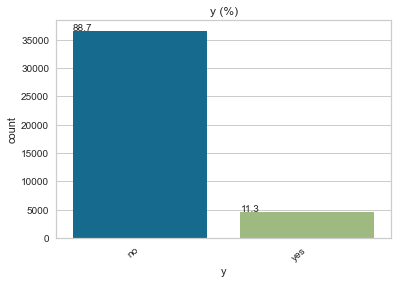

In [217]:
count_plot('y', df)

Let's examine the distribution of job. Top 3 occupations were admin, blue-collar and technician.

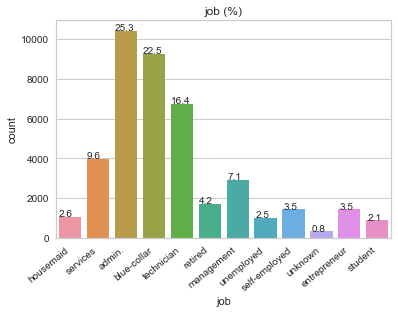

In [218]:
count_plot('job', df)

Let's also examine age distribution by y. We discovered that average age for those who subscribed to term deposit ("yes") is 1 year older than those who did not subscribe ("no"). This might suggest that age matters a little bit in making the decision on subscription to term deposit but personally I cannot conclude that there is a definite relationship as the difference in age between the two group is too small.

In [392]:
df.groupby('y')['age'].mean()

y
no     39.911185
yes    40.913147
Name: age, dtype: float64

In [394]:
df['age'][df['y'] == 'yes'].describe()

count    4640.000000
mean       40.913147
std        13.837476
min        17.000000
25%        31.000000
50%        37.000000
75%        50.000000
max        98.000000
Name: age, dtype: float64

In [393]:
df['age'][df['y'] == 'no'].describe()

count    36548.000000
mean        39.911185
std          9.898132
min         17.000000
25%         32.000000
50%         38.000000
75%         47.000000
max         95.000000
Name: age, dtype: float64

About 33% of samples are from May. It is interesting as 1/3 of campaigns were conducted in a single month alone.

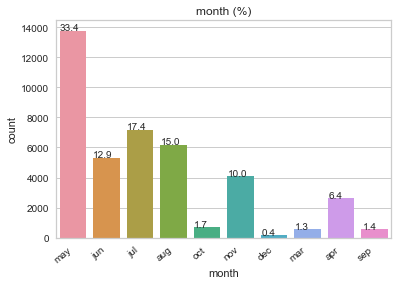

In [220]:
count_plot('month', df)

About 61% of customers who got contacted are married and this gives us a feeling that bank mainly contacted people who are in need of term deposit to support family.

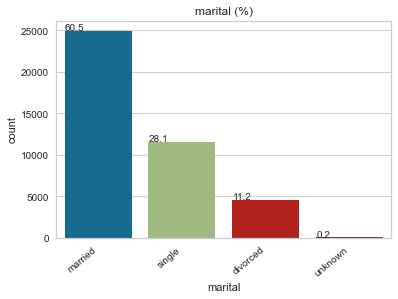

In [221]:
count_plot('marital', df)

## Factor plot - y vs feature

Let's examine the distribution of y by each feature.

In [222]:
def pv_plot(df, feature, group):
    pv = pd.pivot_table(df, index = feature, columns = group, values = 'age', aggfunc = 'count')
    ax = pv.plot(kind = 'bar', subplots = False, figsize=(20,10))
    ax.set_title(group + ' - ' + feature + ' Count' + ' (%)')

    for i, p in enumerate(ax.patches):
        if i%2 == 0:
            ax.annotate( str( round(p.get_height() / len(df[df[feature] == 'no']) * 100 , 1 ) ), (p.get_x() * 1.005, p.get_height() * 1.005), annotation_clip = True)
        else:
            ax.annotate( str( round(p.get_height() / len(df[df[feature] == 'yes']) * 100 , 1 ) ), (p.get_x() * 1.005, p.get_height() * 1.005), annotation_clip = True)

In [223]:
# Build a function to show categorical values disribution
def plot_bar(column, position):
    temp_1 = pd.DataFrame()
    # count categorical values
    temp_1['No_deposit'] = df[df['y'] == 'no'][column].value_counts()
    temp_1['Yes_deposit'] = df[df['y'] == 'yes'][column].value_counts()

    t = temp_1.sum(axis=1)
    tt = pd.concat([temp_1,t], axis = 1)
    tt.columns = ['No_deposit','Yes_deposit','total_cnt']

    tt['Yes_deposit_%'] = tt['Yes_deposit'] / tt['total_cnt']
    tt['No_deposit_%'] = tt['No_deposit'] / tt['total_cnt']

    #ax = tt[['No_deposit_%','Yes_deposit_%']].plot(kind = 'bar')
    dd = tt.reset_index()
    col = dd['index'].unique()

    dd['No_deposit_%'] = round(dd['No_deposit_%'] * 100,1)
    dd['Yes_deposit_%'] = round(dd['Yes_deposit_%'] * 100,1)
    dd.index = temp_1.index
    
    ax = dd[['No_deposit_%','Yes_deposit_%']].plot(kind = 'bar')

    for i, p in enumerate(ax.patches):
        if i in range(int(len(ax.patches) / 2)):
            ax.annotate( dd['No_deposit_%'][dd['index'] == col[i]].values[0], (p.get_x() * 1.005, p.get_height() * 1.005), annotation_clip = True)
        else:
            ax.annotate( dd['Yes_deposit_%'][dd['index'] == col[i-len(col)]].values[0], (p.get_x() * 1.005, p.get_height() * 1.005), annotation_clip = True)
    
    
    plt.xlabel(f'{column}')
    plt.ylabel('% of clients')
    plt.title('Distribution of {} and deposit'.format(column))
    plt.legend(loc=position)
    plt.show()

By job, we discovered that admin is the most frequent occupation for both yes or no. It is interesting that technician is 2nd most frequent occupation for those with yes (around 16% of customers with no are technician) where as it is 3rd most frequent occupation for those with no. In relative term, it is worth noting that students tend to have higher proportion of yes than any other occupations.

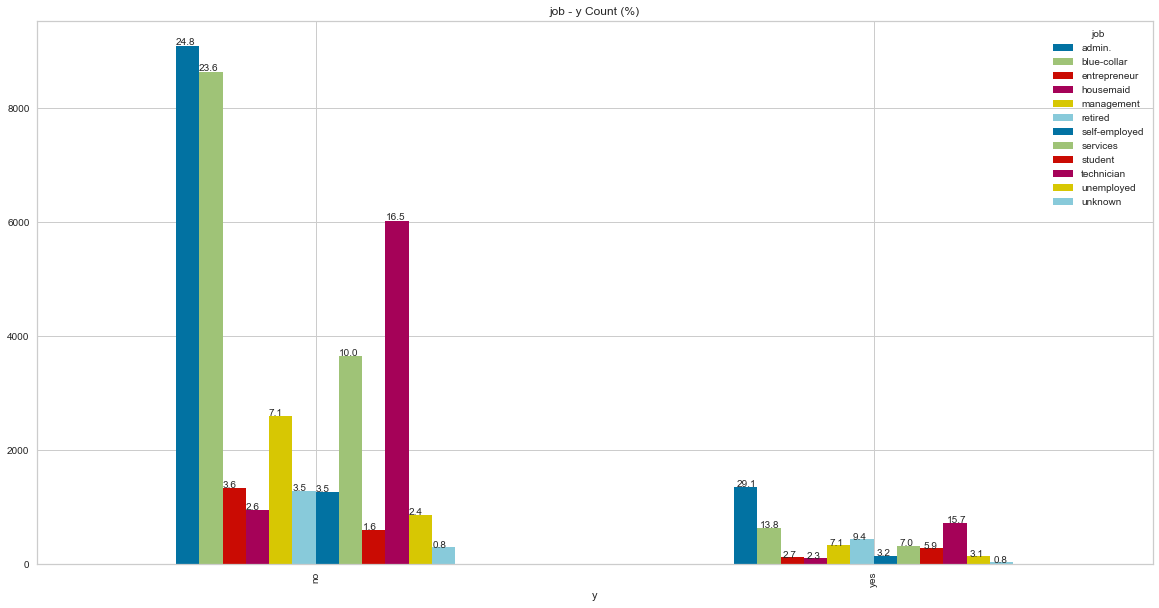

In [224]:
pv_plot(df, 'y', 'job')

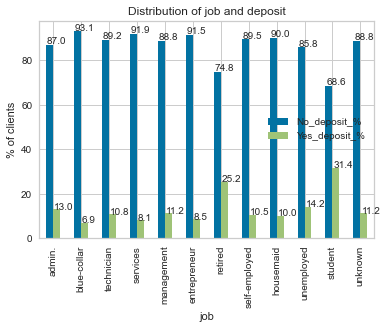

In [225]:
plot_bar('job','center right')

In absolute terms, married customers more often subscribed ("Yes") than any other group but proportionally speaking (in relative term), singles subscribe "Yes" more than any other group, realtively speaking.

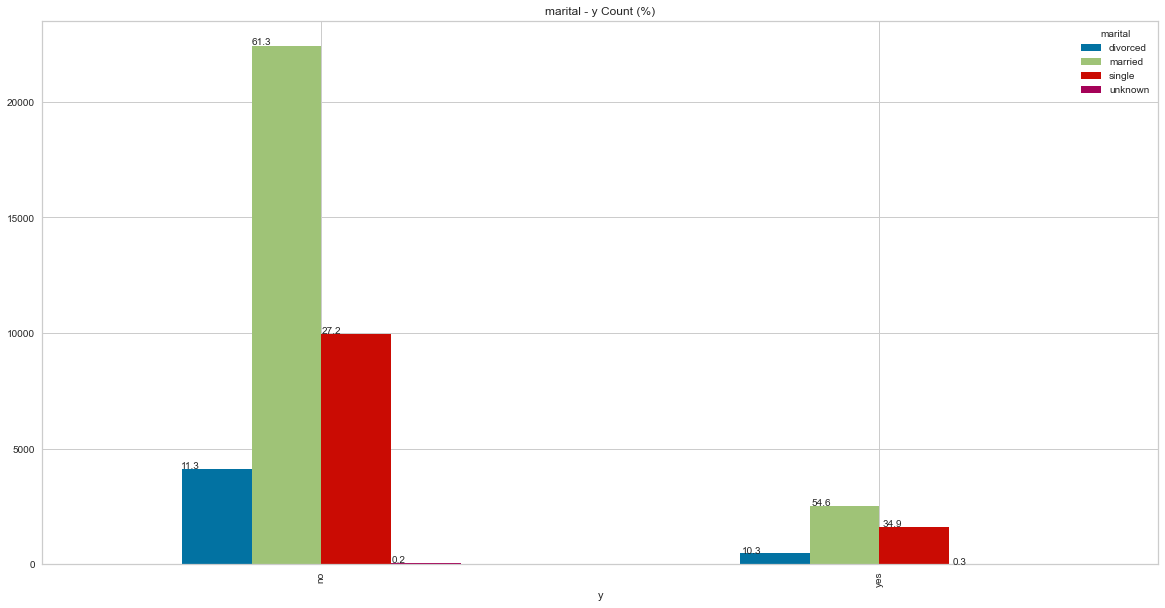

In [226]:
pv_plot(df, 'y', 'marital')

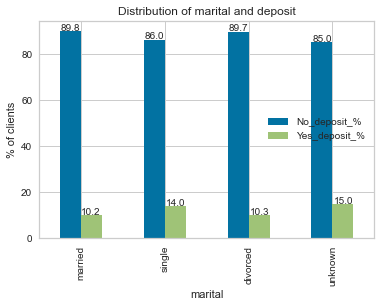

In [227]:
plot_bar('marital', 'center right')

Interestingly enough, customers who were contacted via cellular devices had higher response of "Yes" in both absolute and relative term. This insight makes me think that there is potential opportunity for marketers to promote better - uncover what other variables cause this to happen. For example, from below, we noticed that there are more proportion of university degree holders for customers who are contacted by cellular than customers who are contacted by phone. Obviously, holding cell phone doesn't cause customers hold more university degree but it at least uncovers the fact that customers who have university degree tend to be contacted by cellular phones more often. Thus, we will examine this insight further by education level.

In [333]:
agg = df.groupby('contact').size().reset_index()
grouped = df.groupby(['contact','education']).size().reset_index()
cell_phone = grouped.merge(agg, on = 'contact')
cell_phone.columns = ['contact','education','cnt_contact_education','cnt_contact_agg']
cell_phone['education/contact %'] = ( cell_phone['cnt_contact_education'] / cell_phone['cnt_contact_agg'] ) * 100

In [334]:
cell_phone

,contact,education,cnt_contact_education,cnt_contact_agg,education/contact %
0,cellular,basic.4y,2350,26144,8.988678
1,cellular,basic.6y,1247,26144,4.769737
2,cellular,basic.9y,3452,26144,13.203794
3,cellular,high.school,5928,26144,22.674419
4,cellular,illiterate,15,26144,0.057375
5,cellular,professional.course,3478,26144,13.303244
6,cellular,university.degree,8657,26144,33.112760
7,cellular,unknown,1017,26144,3.889994
8,telephone,basic.4y,1826,15044,12.137729
9,telephone,basic.6y,1045,15044,6.946291


In [335]:
agg = df.groupby('contact').size().reset_index()
grouped = df.groupby(['contact','marital']).size().reset_index()
cell_phone_marital = grouped.merge(agg, on = 'contact')
cell_phone_marital.columns = ['contact','marital','cnt_contact_marital','cnt_contact_agg']
cell_phone_marital['education/contact %'] = ( cell_phone_marital['cnt_contact_marital'] / cell_phone_marital['cnt_contact_agg'] ) * 100



In [336]:
cell_phone_marital

,contact,marital,cnt_contact_marital,cnt_contact_agg,education/contact %
0,cellular,divorced,2908,26144,11.123011
1,cellular,married,15206,26144,58.162485
2,cellular,single,7977,26144,30.511781
3,cellular,unknown,53,26144,0.202723
4,telephone,divorced,1704,15044,11.326775
5,telephone,married,9722,15044,64.623770
6,telephone,single,3591,15044,23.869981
7,telephone,unknown,27,15044,0.179474


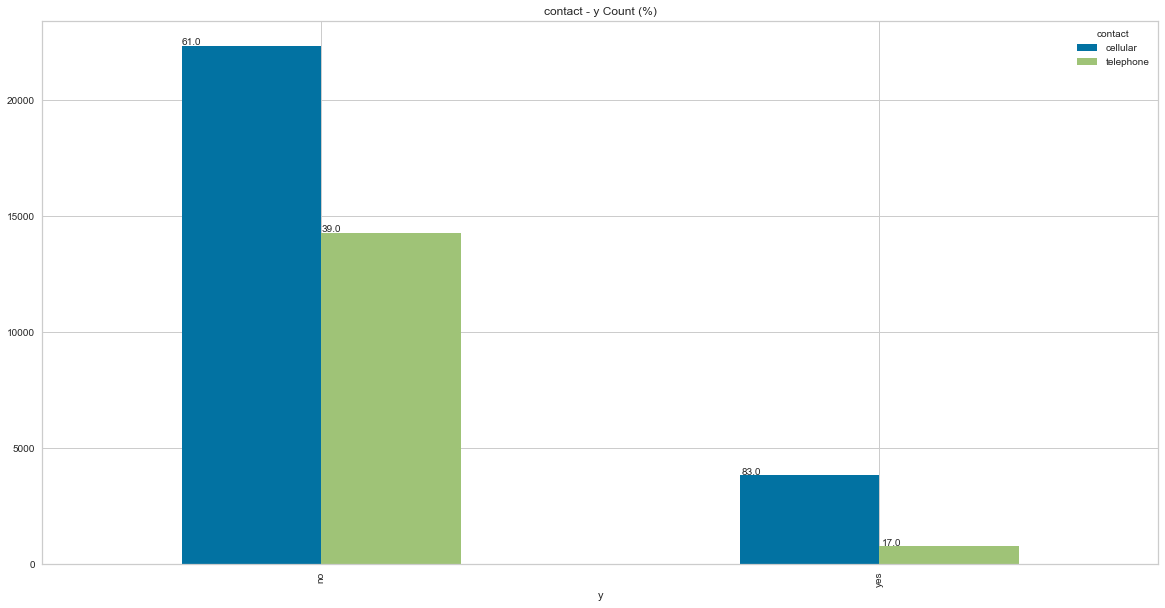

In [228]:
pv_plot(df, 'y', 'contact')

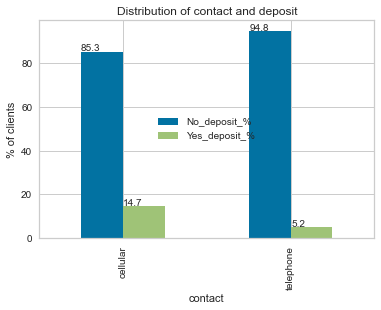

In [314]:
plot_bar('contact','center')

University degree holders had the highest % of "yes" and "no" in absolute term. In relative term, however, illiterate group had the highest % of "yes". However, as you can see from the graph below, since the sample size of is just too small (only 18 in total), we would not consider this result to be accurate.
Also, we know that unknown group had 2nd highest % of "yes" in realative term but since unknown can mean any occupation, we cannot make any conclusion on what it really means by unknown.
Therefore, we may assume that university degree holders have, indeed, highest % of "yes" both in absolute and relative term; and hence, contact university degree holders more often to have more "yes".

What does this tell us? If education feature is one of the most important features in predicting y from model, we can build insight around this feature and make recommendation based on this result.

In [398]:
df.groupby(['y','education']).size()

y    education          
no   basic.4y                3748
     basic.6y                2104
     basic.9y                5572
     high.school             8484
     illiterate                14
     professional.course     4648
     university.degree      10498
     unknown                 1480
yes  basic.4y                 428
     basic.6y                 188
     basic.9y                 473
     high.school             1031
     illiterate                 4
     professional.course      595
     university.degree       1670
     unknown                  251
dtype: int64

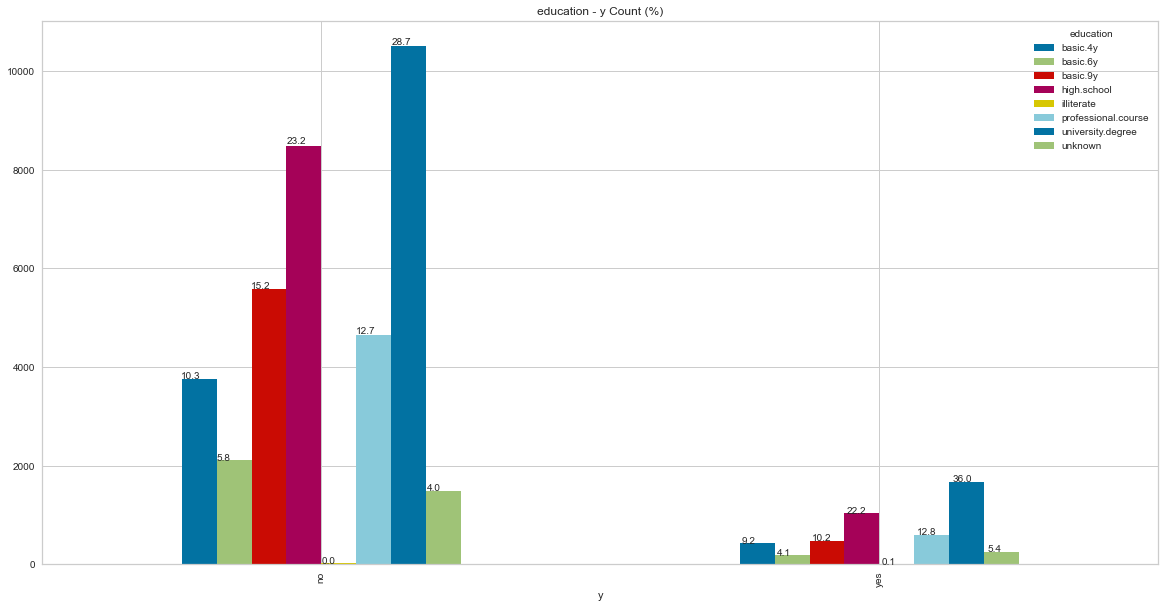

In [396]:
pv_plot(df, 'y', 'education')

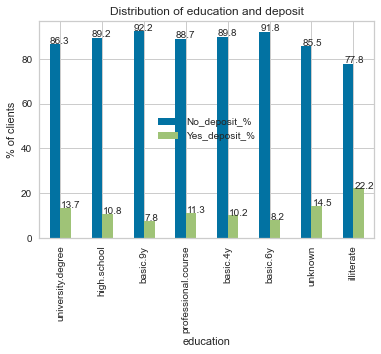

In [401]:
plot_bar('education', 'center')

In relative term, proportion of Yes_deposit is especially high (>40%) during March, September, October and December but given that sample sizes during these months are so small, we cannot really make conclusion that customers say "Yes" more often in relative term during these months for sure; these might have happened due to random chance. However, it is worth investigating further to fully examine if there is any seasonality effect - it maybe actually true (after conducting more phone calls and increasing sample size) that customers responded with "yes" more mostly during near the end of the year or end of Q1 each year and if this is true, campaign marketers should uncover why it is the case (e.g. is it because marketers had promotion during these months? If not, maybe there are other socio-economic or behavioral reasoning behind as to why customers say "Yes" more often during these particular months - marketers need to uncover more on this to understand "why" it is. We will check if month variable is important variable in predicting subscription of term deposit.

It is also notable that "no" is highest during May both in relative and absolute term - maybe marketers spamming too many phone calls during this month? If so, they will need to change their strategy. Another question that we want to ask that is beyond the scope from this data set is, is there any particular reason why 1/3 of total phone calls are coming from May alone, as we found out early on? We will see if month_may feature is indeed one of the most important features in predicting y later on.

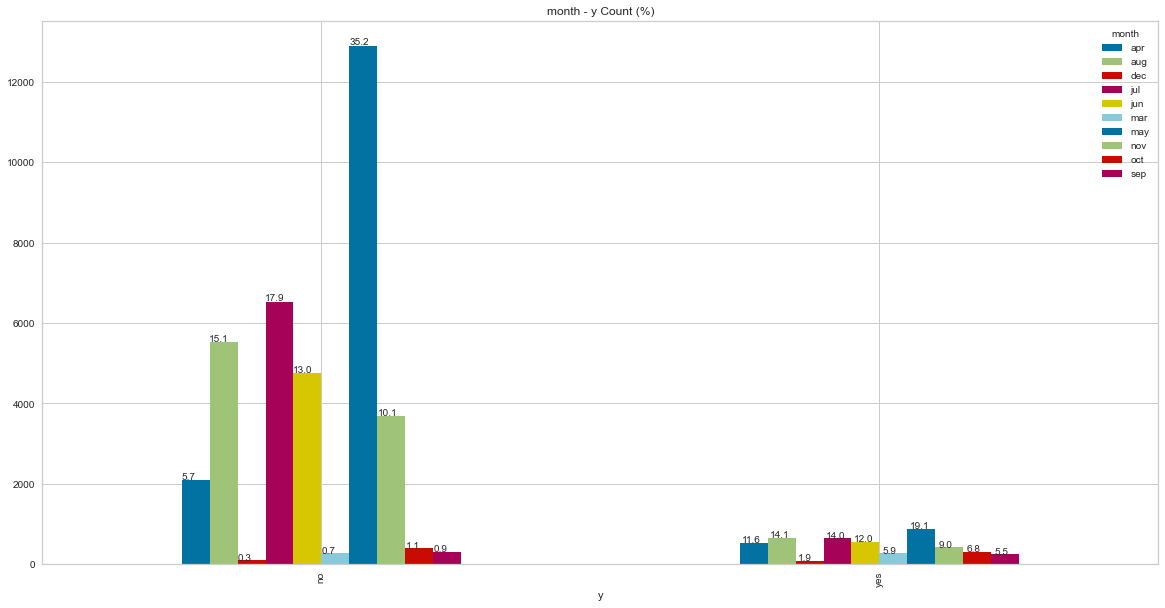

In [230]:
pv_plot(df, 'y', 'month')

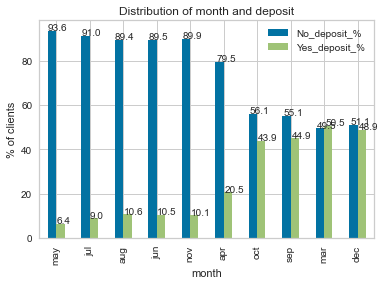

In [231]:
plot_bar('month', 'upper right')

In relative term, Thursday has the highest response rate of "Yes" when Monday has the highest response rate of "No". Marketers would need to uncover as to why this is the case.

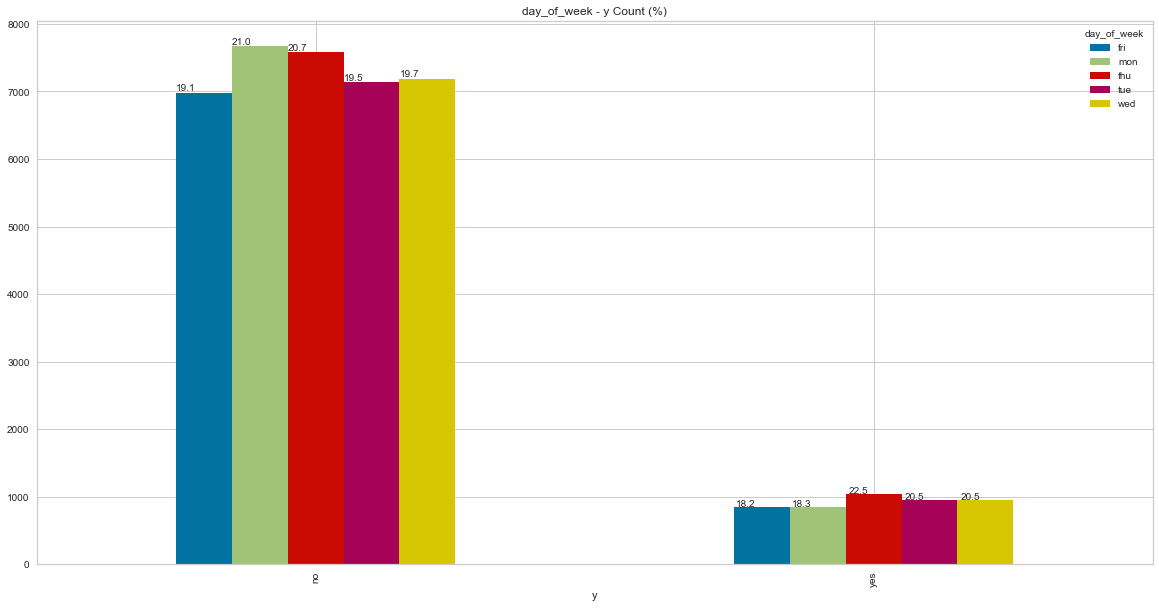

In [338]:
pv_plot(df, 'y', 'day_of_week')

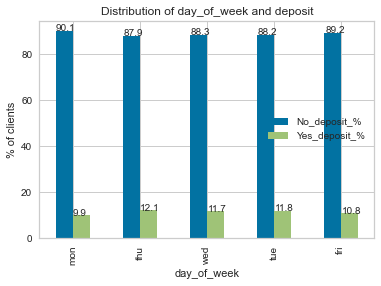

In [344]:
plot_bar('day_of_week', 'center right')

Having personal loan or not does not seem to affect the decision of subscription of term deposit that much. In relative term, for example, we see that customers who have personal loan tend to have higher proportion of "No" but not by so much.

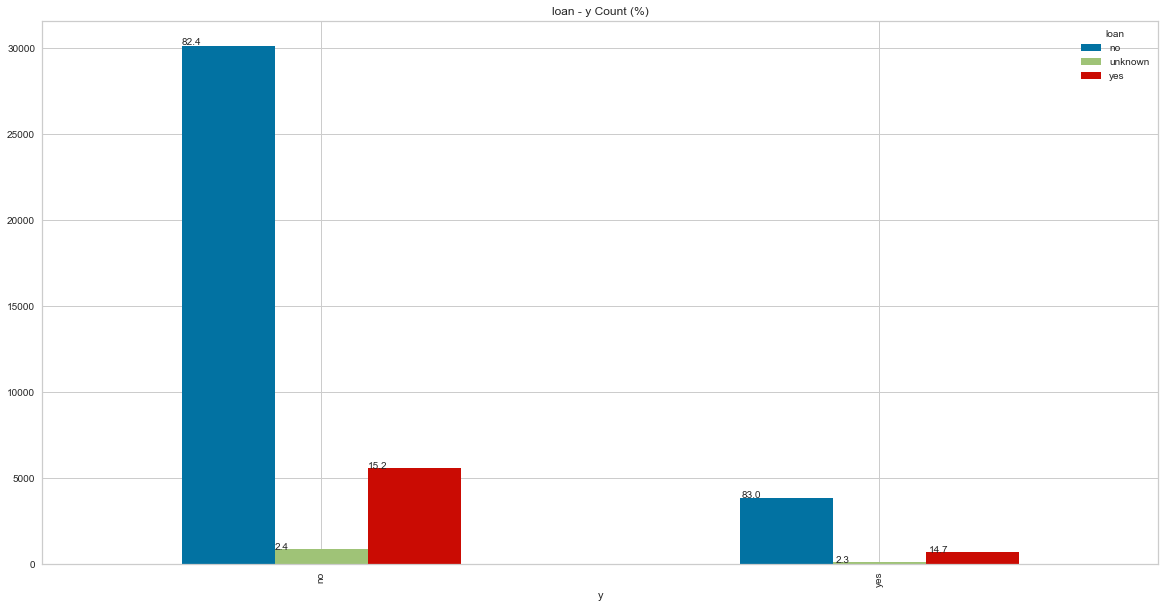

In [340]:
pv_plot(df, 'y', 'loan')

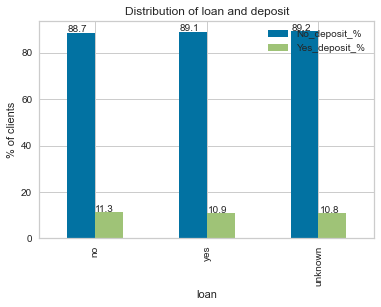

In [342]:
plot_bar('loan', 'best')

## Feature selection
As we already disccused, we removed highly correlated variables (abs(corr) > 0.9 OR one of the 2 levels in dummy variables) as it can especially hurt when it comes to interpreting the feature importance in tree-based models; one of them carry the same or similar information as the other. We will, however, still keep one hot encoded variables with multi values (> 2) in sparse matrix.

Given that, we will then once again separate x and y based on df_model dataframe that removed highly correlated variables.

In [232]:
x = df_model.drop('y', axis=1)
y = df_model['y']

# Modeling

1. We will first create a Random Forest model without handling the imbalance. This is to create baseline model that can be compared to other models. 

2. We will then create a Random Forest model after handling the imbalance by configuring parameter (class_weight = 'balanced').

3. A study suggests that pre-processing is recommended even for Random Forest, in case of imbalanced data, as it may improve predictive power further. We will thus implement Random Forest model with SMOTE (Synthetic Minority Oversampling Technique) as well to examine pre-processing effect in Random Forest model.(reference: https://www.researchgate.net/publication/329507455_Studying_Weariness_Prediction_Using_SMOTE_and_Random_Forests_Third_International_Conference_SmartCom_2018_Tokyo_Japan_December_10-12_2018_Proceedings) 

4. XGboost, a boosting algorithm, which adjusts weights to handle imbalance will be implemented as well. Parameter tuning is required to set correct scale_pos_weight.

5. XGboost with SMOTE will be implemented.

For performance evaluation metrics, accuracy will be still calculated just as a reference but will not be used for evaluation. As a reference, PR-AUC curve was also implemented but for more realistic evaluation, we will examine combination of ROC-AUC, Precision, Recall and F1 altogether to realistically assess the model for imbalanced class.
(reference: https://stats.stackexchange.com/questions/262616/roc-vs-precision-recall-curves-on-imbalanced-dataset)

Hyperparameter tuning had been done for each modelling (code is put in appendix section). Selection of best parameters was based on ROC-AUC score on test set (choose best parameters that yield the lowest average ROC-AUC on test sets from K-fold cross validation). As there was a time limit (submit by Sunday), I could not spend too much time on this process so bear in mind that ROC-AUC or F1 score might not be the optimal and obviously there is a room for improvement in the future to obtain better model that may produce higher ROC-AUC/f1/precision/recall on test set than the current best model. Of course, I believe the purpose of this excercise was not necessarily to create best performing model but more of showcase of overall modelling techniques. Furthermore, my computer is often too slow to run hyperparmeter tuning so maybe in the future, once we have better machine, we may do more of hyperparameter tuning to improve the model further. In addition, for the future study, one may consider deeper feature engineering to improve model performance.

SMOTE is applied for train set only (after train-test split) and then tested on test set that is untouched; no SMOTE was applied on test set as it can lead to data leakage. (reference: https://datascience.stackexchange.com/questions/15630/train-test-split-after-performing-smote)

#### Highlights

Summary of the best model chosen (Random Forest (SMOTE)):
    
* precision (weighted avg): 0.88
* recall (weighted avg): 0.86
* f1-score (weighted avg): 0.87
* ROC-AUC score on test set: ~0.74 (much better than Random Forest (baseline) that used non-SMOTE original train set with ~0.61)
    
I chose Random Forest (SMOTE) as the best model since it had high enough precision, recall, f1 and ROC-AUC score (overall a model with good balance of each metric - for our purpose I would give importance as f1 > precision = recall = ROC-AUC score and in fact, Random Forest (SMOTE) also had highest f1 score in terms of weighted average among all models). 

Top 11 most important features in predicting "y" (deposit subscribe yes = 1, deposit subscribe no = 0) from the best model are following:

* euribor3m
* cons.conf.idx
* cons.price.idx
* poutcome_nonexistent
* month_may
* poutcome_failure
* day_of_week_mon
* job_blue_collar
* poutcome_failure
* day_of_week_fri
* loan_yes

#### Analysis/recommendation - insights from feature importance plot of Random Forest (SMOTE)

Macroeconomic indicators such as euribor3m, cons.conf.idx and cons.price,idx affect hugely on the campaign's outcome.
For example, it is true that the mean of consumer price index is lower for groups who said "yes" (93.4 - yes vs 93.6 - no) and it could be that difference in consumer price in general may lead consumers to induce more deposit subscription behavior.
However, we cannot really have much control on these macro-economic variables as we cannot change them to alter customer's behavior. (For example, we cannot just simply lower/increase euribor to change customers' behavior. This is done by government or financial instruments and it is often beyond marketers' control).
 
Therefore, to recommend marketers, I would focus more on features that marketers can change.
Month_may variable is something marketers can consider as marketers may change the date of phone calls.
From factor plot analysis early on, we learned that consumers who got contacted during May have a tendency to say "No" to the campaign much more often than any other month. 

Hence, our discovery may prove that spamming customers via phone call during May is usually a bad idea and marketers may need to think twice when they make marketing strategy. Or, it could be that May is just a month where some non-controllable macro-economic variables affect the decision of term deposit (e.g, maybe in May, EU central bank put higher restriction for owning term deposit in Portgual).

From factor plot analysis early on, we also learned that blue collar customers tend to respond as "No" more often than any other customers and hence, it may not be a wise idea to target them. In fact, we may want to recommend marketers to target students or retired customers more often as they tend to say "Yes" more often.

Similarly, we also learned from factor plot analysis that customers who got contacted on Monday had the highest % of "No" and that being said, marketers may want to examine "why" further. In fact, "Yes" % is the highest during Thursday and marketers probably need to examine why and make phone calls on Thursday more often.

Also, we learned that degree holders tend to respond with "yes" more often; and these customers tend to get contacted via cell phones more often. Marketers may focus more on contacting degree holders more often to achieve higher term deposit subscription rate, if possible.

In [400]:
df.groupby('y')['cons.price.idx'].mean()

y
no     93.603757
yes    93.354386
Name: cons.price.idx, dtype: float64

# train-test split
80/20 (train/test) will be implemented for modeling.

In [233]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 49 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41188 non-null  int64  
 1   job_housemaid                  41188 non-null  int64  
 2   job_services                   41188 non-null  int64  
 3   job_admin.                     41188 non-null  int64  
 4   job_blue-collar                41188 non-null  int64  
 5   job_technician                 41188 non-null  int64  
 6   job_retired                    41188 non-null  int64  
 7   job_management                 41188 non-null  int64  
 8   job_unemployed                 41188 non-null  int64  
 9   job_self-employed              41188 non-null  int64  
 10  job_entrepreneur               41188 non-null  int64  
 11  job_student                    41188 non-null  int64  
 12  marital_married                41188 non-null 

In [234]:
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.metrics import roc_auc_score,roc_curve#,scorer
from sklearn.metrics import f1_score
import statsmodels.api as sm
from sklearn.metrics import precision_score,recall_score
import matplotlib.pyplot as plt#visualization
from PIL import  Image
%matplotlib inline
import pandas as pd
import seaborn as sns#visualization
import itertools
import warnings
warnings.filterwarnings("ignore")
import io
import plotly.offline as py#visualization
py.init_notebook_mode(connected=True)#visualization
import plotly.graph_objs as go#visualization
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
from yellowbrick.classifier import DiscriminationThreshold
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
trainX, testX, trainY, testY = train_test_split(x,y,test_size=0.20, random_state=2019)

# Data preparation for modeling

In [235]:
# SMOTE - apply on train set only
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_sample(trainX, trainY)

X_res = pd.DataFrame(data = X_res, columns=trainX.columns)
#y_res = pd.DataFrame(data = os_smote_Y,columns=trainY.columns)

# Function for prediction

In [236]:
def bmo_prediction(algorithm,training_x,testing_x,
                             training_y,testing_y,cols,cf) :
    algorithm.fit(training_x, training_y)
    predictions   = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
    #coeffs
    if   cf == "coefficients" :
        coefficients  = pd.DataFrame(algorithm.coef_.ravel())
    elif cf == "features" :
        coefficients  = pd.DataFrame(algorithm.feature_importances_)
        
    column_df     = pd.DataFrame(cols)
    coef_sumry    = (pd.merge(coefficients,column_df,left_index= True,
                              right_index= True, how = "left"))
    coef_sumry.columns = ["coefficients","features"]
    coef_sumry    = coef_sumry.sort_values(by = "coefficients",ascending = False)
    
    print (algorithm)
    print ("\n Classification report : \n",classification_report(testing_y, predictions, target_names= ['No_deposit','Yes_deposit']))
    print ("Accuracy Score : ",accuracy_score(testing_y,predictions))
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y,predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y,predictions) 
    print ("Area under curve : ",model_roc_auc,"\n")
    fpr,tpr,thresholds = roc_curve(testing_y,probabilities[:,1])
    
    #plot confusion matrix
    trace1 = go.Heatmap(z = conf_matrix ,
                        x = ["No deposit","Yes deposit"],
                        y = ["No deposit","Tes deposit"],
                        showscale  = False,colorscale = "Picnic",
                        name = "matrix")
    
    #plot roc curve
    trace2 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2))
    trace3 = go.Scatter(x = [0,1],y=[0,1],
                        line = dict(color = ('rgb(205, 12, 24)'),width = 2,
                        dash = 'dot'))
    
    #plot coeffs
    trace4 = go.Bar(x = coef_sumry["features"],y = coef_sumry["coefficients"],
                    name = "coefficients",
                    marker = dict(color = coef_sumry["coefficients"],
                                  colorscale = "Picnic",
                                  line = dict(width = .6,color = "black")))
    
    #subplots
    fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                            subplot_titles=('Confusion Matrix',
                                            'Receiver operating characteristic',
                                            'Feature Importances'))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,1,2)
    fig.append_trace(trace4,2,1)
    
    fig['layout'].update(showlegend=False, title="Model performance" ,
                         autosize = False,height = 900,width = 800,
                         plot_bgcolor = 'rgba(240,240,240, 0.95)',
                         paper_bgcolor = 'rgba(240,240,240, 0.95)',
                         margin = dict(b = 195))
    fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))
    fig["layout"]["xaxis3"].update(dict(showgrid = True,tickfont = dict(size = 10),
                                        tickangle = 90))
    
    #py.init_notebook_mode(connected=False)
    py.iplot(fig)
    

## Model 1: Random Forest (baseline)

In [305]:
# RFs
rf1 = RandomForestClassifier(n_estimators=2500, max_depth=10, random_state=42)
#rf2 = RandomForestClassifier(n_estimators=2500, class_weight = 'balanced', max_depth=4, random_state=42)
rf2 = RandomForestClassifier(n_estimators=2500, class_weight = 'balanced', max_depth=8, random_state=42)

In [306]:
bmo_prediction(rf1,trainX,testX,trainY,testY,
                         trainX.columns,"features")

RandomForestClassifier(max_depth=10, n_estimators=2500, random_state=42)

 Classification report : 
               precision    recall  f1-score   support

  No_deposit       0.91      0.99      0.94      7267
 Yes_deposit       0.72      0.22      0.34       971

    accuracy                           0.90      8238
   macro avg       0.81      0.61      0.64      8238
weighted avg       0.88      0.90      0.87      8238

Accuracy Score :  0.8983976693372178
Area under curve :  0.6060297265249834 



In [307]:
# rf1.fit(trainX, trainY)
# # predict probabilities
# lr_probs = rf1.predict_proba(testX)
# # keep probabilities for the positive outcome only
# lr_probs = lr_probs[:, 1]
# # predict class values
# yhat = rf1.predict(testX)
# lr_precision, lr_recall, _ = precision_recall_curve(testY, lr_probs)
# lr_f1, lr_auc = f1_score(testY, yhat), auc(lr_recall, lr_precision)
# # summarize scores
# print('Random Forest (baseline): f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# # plot the precision-recall curves
# no_skill = len(testY[testY==1]) / len(testY)
# pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
# pyplot.plot(lr_recall, lr_precision, marker='.', label='RF')
# # axis labels
# pyplot.xlabel('Recall')
# pyplot.ylabel('Precision')
# # show the legend
# pyplot.legend()
# # show the plot
# pyplot.show()

## Model 2: Random Forest (class_weight = 'Balanced')

In [308]:
bmo_prediction(rf2,trainX,testX,trainY,testY,
                         trainX.columns,"features")

RandomForestClassifier(class_weight='balanced', max_depth=8, n_estimators=2500,
                       random_state=42)

 Classification report : 
               precision    recall  f1-score   support

  No_deposit       0.94      0.87      0.91      7267
 Yes_deposit       0.39      0.61      0.48       971

    accuracy                           0.84      8238
   macro avg       0.67      0.74      0.69      8238
weighted avg       0.88      0.84      0.86      8238

Accuracy Score :  0.8413449866472444
Area under curve :  0.7427746041562829 



In [309]:
# rf2.fit(trainX, trainY)
# # predict probabilities
# lr_probs = rf2.predict_proba(testX)
# # keep probabilities for the positive outcome only
# lr_probs = lr_probs[:, 1]
# # predict class values
# yhat = rf2.predict(testX)
# lr_precision, lr_recall, _ = precision_recall_curve(testY, lr_probs)
# lr_f1, lr_auc = f1_score(testY, yhat), auc(lr_recall, lr_precision)
# # summarize scores
# print('Random Forest (baseline): f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# # plot the precision-recall curves
# no_skill = len(testY[testY==1]) / len(testY)
# pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
# pyplot.plot(lr_recall, lr_precision, marker='.', label='RF')
# # axis labels
# pyplot.xlabel('Recall')
# pyplot.ylabel('Precision')
# # show the legend
# pyplot.legend()
# # show the plot
# pyplot.show()

## Model 3: Random Forest (SMOTE)

In [311]:
bmo_prediction(rf1,X_res,testX,y_res,testY,
                         trainX.columns,"features")

RandomForestClassifier(max_depth=10, n_estimators=2500, random_state=42)

 Classification report : 
               precision    recall  f1-score   support

  No_deposit       0.94      0.90      0.92      7267
 Yes_deposit       0.44      0.57      0.50       971

    accuracy                           0.86      8238
   macro avg       0.69      0.74      0.71      8238
weighted avg       0.88      0.86      0.87      8238

Accuracy Score :  0.8624666181111921
Area under curve :  0.7377936347839938 



In [303]:
# rf1.fit(X_res, y_res)
# # predict probabilities
# lr_probs = rf1.predict_proba(testX)
# # keep probabilities for the positive outcome only
# lr_probs = lr_probs[:, 1]
# # predict class values
# yhat = rf1.predict(testX)
# lr_precision, lr_recall, _ = precision_recall_curve(testY, lr_probs)
# lr_f1, lr_auc = f1_score(testY, yhat), auc(lr_recall, lr_precision)
# # summarize scores
# print('Random Forest (baseline): f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# # plot the precision-recall curves
# no_skill = len(testY[testY==1]) / len(testY)
# pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
# pyplot.plot(lr_recall, lr_precision, marker='.', label='RF')
# # axis labels
# pyplot.xlabel('Recall')
# pyplot.ylabel('Precision')
# # show the legend
# pyplot.legend()
# # show the plot
# pyplot.show()

## Model 4: XGBoost (balanced by scale_pos_weight)

In [250]:
from xgboost import XGBClassifier

w_ratio=trainY.value_counts()[0]/trainY.value_counts()[1]
xgb1 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                    colsample_bytree=1, gamma=0, learning_rate=0.9, max_delta_step=0,
                    max_depth = 7, min_child_weight=1, n_estimators=100,
                    n_jobs=1, objective='binary:logistic', random_state=42,
                    reg_alpha=0, reg_lambda=1, scale_pos_weight=w_ratio, seed=None,
                    silent=True, subsample=1)



#w_ratio2=pd.Series(y_res).value_counts()[0]/pd.Series(y_res).value_counts()[1]
xgb2 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                    colsample_bytree=1, gamma=0, learning_rate=0.9, max_delta_step=0,
                    max_depth = 7, min_child_weight=1, n_estimators=100,
                    n_jobs=1, objective='binary:logistic', random_state=42,
                    reg_alpha=0, reg_lambda=1, #scale_pos_weight=w_ratio2, 
                     seed=None,
                    silent=True, subsample=1)

In [251]:
bmo_prediction(xgb1,trainX,testX,trainY,testY,
                         trainX.columns,"features")

[16:08:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:08:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.9, max_delta_step=0, max_depth=7,
              min_child_weight=

In [252]:
# xgb1.fit(trainX, trainY)
# # predict probabilities
# lr_probs = xgb1.predict_proba(testX)
# # keep probabilities for the positive outcome only
# lr_probs = lr_probs[:, 1]
# # predict class values
# yhat = model.predict(testX)
# lr_precision, lr_recall, _ = precision_recall_curve(testY, lr_probs)
# lr_f1, lr_auc = f1_score(testY, yhat), auc(lr_recall, lr_precision)
# # summarize scores
# print('Random Forest (baseline): f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# # plot the precision-recall curves
# no_skill = len(testY[testY==1]) / len(testY)
# pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
# pyplot.plot(lr_recall, lr_precision, marker='.', label='RF')
# # axis labels
# pyplot.xlabel('Recall')
# pyplot.ylabel('Precision')
# # show the legend
# pyplot.legend()
# # show the plot
# pyplot.show()

## Model 5: XGBoost (SMOTE)

In [253]:
bmo_prediction(xgb2,X_res,testX,y_res,testY,
                         trainX.columns,"features")

[16:08:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:08:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.9, max_delta_step=0, max_depth=7,
              min_child_weight=

In [254]:
# xgb2.fit(X_res, y_res)
# # predict probabilities
# lr_probs = xgb2.predict_proba(testX)
# # keep probabilities for the positive outcome only
# lr_probs = lr_probs[:, 1]
# # predict class values
# yhat = xgb2.predict(testX)
# lr_precision, lr_recall, _ = precision_recall_curve(testY, lr_probs)
# lr_f1, lr_auc = f1_score(testY, yhat), auc(lr_recall, lr_precision)
# # summarize scores
# print('Random Forest (baseline): f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# # plot the precision-recall curves
# no_skill = len(testY[testY==1]) / len(testY)
# pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
# pyplot.plot(lr_recall, lr_precision, marker='.', label='RF')
# # axis labels
# pyplot.xlabel('Recall')
# pyplot.ylabel('Precision')
# # show the legend
# pyplot.legend()
# # show the plot
# pyplot.show()

## Model 6: ANN - Centered/Scaled

Since it requires too much computation power (often took more than an hour to finish), I would not consider ANN for now but here is a reference code.

In [239]:
#from sklearn.utils.class_weight import compute_class_weight
#weights = compute_class_weight('balanced', np.unique(trainY), trainY)
#weights

In [69]:
# from keras.layers import BatchNormalization
# from keras.models import Sequential
# from keras.layers import Dropout
# from keras.layers import Dense
# from keras.wrappers.scikit_learn import KerasClassifier

# classifier = Sequential()

# # input layer
# classifier.add(Dense(units=6,kernel_initializer="uniform",activation="relu",input_shape=(46,)))
# classifier.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center = True, scale = True)) # center, scale is effective for our case

# # hidden layer 1
# classifier.add(Dense(units=6,kernel_initializer="uniform",activation="relu"))
# classifier.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center = True, scale = True))

# # hidden layer 2
# classifier.add(Dense(units=6,kernel_initializer="uniform",activation="relu"))
# classifier.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center = True, scale = True))

# # output layer
# classifier.add(Dropout(0.2))
# classifier.add(Dense(units=1,kernel_initializer="uniform",activation="sigmoid")) #softmax isn't effective for our case

# classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# # fit the model
# classifier.fit(trainX, trainY,  batch_size = 100, nb_epoch = 100)

In [70]:
# predictions = classifier.predict(testX)
# predictions = (predictions > 0.5)


# print ("\n Classification report : \n",classification_report(testY, predictions, target_names= ['Stayed','Churned']))
# print ("Accuracy Score : ",accuracy_score(testY,predictions))
# #confusion matrix
# #conf_matrix = confusion_matrix(testY,predictions)
# #conf_matrix
# #roc_auc_score
# model_roc_auc = roc_auc_score(testY,predictions) 
# print ("Area under curve : ",model_roc_auc,"\n")

## Model 7: ANN (SMOTE)

In [71]:
# classifier2 = Sequential()

# # input layer
# classifier2.add(Dense(units=6,kernel_initializer="uniform",activation="relu",input_shape=(46,)))
# classifier2.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))

# # hidden layer 1
# classifier2.add(Dense(units=6,kernel_initializer="uniform",activation="relu"))
# classifier2.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))

# # hidden layer 2
# classifier2.add(Dense(units=6,kernel_initializer="uniform",activation="relu"))
# classifier2.add(BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001))

# # output layer
# classifier2.add(Dropout(0.2))
# classifier2.add(Dense(units=1,kernel_initializer="uniform",activation="sigmoid")) #softmax isn't effective for our case

# classifier2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# # fit the model
# classifier2.fit(X_res, y_res, batch_size = 100, nb_epoch = 100)

In [72]:
# predictions = classifier2.predict(testX)
# predictions = (predictions > 0.5)


# print ("\n Classification report : \n",classification_report(testY, predictions, target_names= ['Stayed','Churned']))
# print ("Accuracy Score : ",accuracy_score(testY,predictions))
# #confusion matrix
# #conf_matrix = confusion_matrix(testY,predictions)
# #conf_matrix
# #roc_auc_score
# model_roc_auc = roc_auc_score(testY,predictions) 
# print ("Area under curve : ",model_roc_auc,"\n")

# Appendix - as reference

## Permutation importance

I did not use this as a metrics but worth investigating into. Permutation importance can be used to remove bias towards continous variables for tree-based models.

In [346]:
#XGB (SMOTE) - permutation importance (test)
#!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf2, scoring="f1", random_state=42).fit(testX, testY)
eli5.show_weights(perm, feature_names = trainX.columns.tolist())

Weight,Feature
0.1462 ± 0.0069,euribor3m
0.0500 ± 0.0028,month_may
0.0481 ± 0.0023,cons.conf.idx
0.0344 ± 0.0058,cons.price.idx
0.0163 ± 0.0030,poutcome_failure
0.0066 ± 0.0016,month_oct
0.0065 ± 0.0016,previous
0.0064 ± 0.0014,month_apr
0.0051 ± 0.0006,poutcome_nonexistent
0.0047 ± 0.0022,month_jun


## Hyperparmeter tuning

Used the code below to search for the best parameters in terms of ROC-AUC score on test set for given parameters for Random Forest and XGBoost. The k-fold cross validation was used to do the hyperparmeter tuning.

In [ ]:
# def randomforrest(train,validation,n_estimator=1,max_depth=2):
#     '''Random Forest model to fit the training set to random forest and compute AUC on test/validation set'''
#     X=list(train.columns) #Provides indices to split data in train/test sets
#     Y='y_yes'
#     X.remove('y_yes')
#     xtrain=train[X]
#     ytrain=train[Y]
#     xval=validation[X]
#     yval=validation[Y]
    
#     #Run sklearn's random forest algorithm with 128 trees and a minimum split size of 2 and minimum leaf size 1
#     random_forest = RandomForestClassifier(n_estimators=n_estimator,max_depth = max_depth)
    
#     #Train the model
#     random_forest.fit(xtrain,ytrain)
    
#     #Predict target values
#     Y_pred = random_forest.predict(xval)
    
#     #Predict class probabilities of input validation data
#     proba_val=random_forest.predict_proba(xval)[:,1]
    
#     #Compute ROC
#     fpr, tpr, thresholds=metrics.roc_curve(yval,proba_val)
    
#     #Compute ROC AUC scores from prediction values
#     score=metrics.roc_auc_score(yval,proba_val)
    
#     #Feature importances. The higher the score, the more important the feature. 
#     #Computed as the normalized total reduction of the criterion brought by that feature.
#     importance=random_forest.feature_importances_
#     accuracy=metrics.accuracy_score(yval,random_forest.predict(xval))
#     return score,importance,tpr,fpr,thresholds,accuracy

In [ ]:
# def xgb(train,validation,learning_rate=0.9,max_depth=2):
#     '''Random Forest model to fit the training set to random forest and compute AUC on test/validation set'''
#     X=list(train.columns) #Provides indices to split data in train/test sets
#     Y='y_yes'
#     X.remove('y_yes')
#     xtrain=train[X]
#     ytrain=train[Y]
#     xval=validation[X]
#     yval=validation[Y]

    
#     #w_ratio2=pd.Series(y_res).value_counts()[0]/pd.Series(y_res).value_counts()[1]
#     xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
#                     colsample_bytree=1, gamma=0, learning_rate=learning_rate, max_delta_step=0,
#                     max_depth = max_depth, min_child_weight=1, n_estimators=100,
#                     n_jobs=1, objective='binary:logistic', random_state=42,
#                     reg_alpha=0, reg_lambda=1, seed=None,
#                     silent=True, subsample=1)
    
#     #Train the model
#     random_forest.fit(xtrain,ytrain)
    
#     #Predict target values
#     Y_pred = random_forest.predict(xval)
    
#     #Predict class probabilities of input validation data
#     proba_val=random_forest.predict_proba(xval)[:,1]
    
#     #Compute ROC
#     fpr, tpr, thresholds=metrics.roc_curve(yval,proba_val)
    
#     #Compute ROC AUC scores from prediction values
#     score=metrics.roc_auc_score(yval,proba_val)
    
#     #Feature importances. The higher the score, the more important the feature. 
#     #Computed as the normalized total reduction of the criterion brought by that feature.
#     importance=random_forest.feature_importances_
#     accuracy=metrics.accuracy_score(yval,random_forest.predict(xval))
#     return score,importance,tpr,fpr,thresholds,accuracy

In [ ]:
# from sklearn.cross_validation import KFold
# from sklearn import metrics
# from sklearn import preprocessing



# def kfoldRF(dataset, k,ne,md):
#     '''K-fold validation function for XGB and Random Forest. K=5, hence input data set is divided 
#     into 5 datasets out of which 4 of them will be used to fit model and one to validate the model in each iteration '''
#     aucs={}
#     #pr_aucs = {}
#     kf=KFold(len(dataset),k) #Provides indices to split data in train/test sets
    
    
#     for train_idx, vali_idx in kf: 
#         cv_train,cv_validate=dataset.iloc[train_idx,:], dataset.iloc[vali_idx,:]
#         for sp in ne:
#             for lf in md:
#                     core,fimp,tpr,fpr,threshold,accuracy=randomforrest(cv_train,cv_validate,sp,lf)
                
#                 if str(sp)+"L"+str(lf) in aucs:
#                     aucs[str(sp)+"L"+str(lf)].append(core)
#                 else:
#                     aucs[str(sp)+"L"+str(lf)]=[]
#                     aucs[str(sp)+"L"+str(lf)].append(core)
#     return aucs, #pr-aucs

In [ ]:
# #lr = [0.1,0.2,0.3,0.4,0.9,1]
# #md = [1,3,7]

# def kfoldXGB(dataset, k,lr,md):
#     '''K-fold validation function for XGB. K=5, hence input data set is divided 
#     into 5 datasets out of which 4 of them will be used to fit model and one to validate the model in each iteration '''
#     aucs={}
#     #pr_aucs = {}
#     kf=KFold(len(dataset),k) #Provides indices to split data in train/test sets
    
    
#     for train_idx, vali_idx in kf: 
#         cv_train,cv_validate=dataset.iloc[train_idx,:], dataset.iloc[vali_idx,:]
#         for sp in lr:
#             for lf in md:
#                     core,fimp,tpr,fpr,threshold,accuracy=xgb(cv_train,cv_validate,sp,lf)
                
#                 if str(sp)+"L"+str(lf) in aucs:
#                     aucs[str(sp)+"L"+str(lf)].append(core)
#                 else:
#                     aucs[str(sp)+"L"+str(lf)]=[]
#                     aucs[str(sp)+"L"+str(lf)].append(core)
#     return aucs, #pr-aucs